# Analysis and Visualization

In this notebook we perform some analysis and visualization of the historical Bixi trip data.

**TBA**:
* Visualizations on the overall bixi usage in addition to just Metro Mont-Royal.
* Plots of trip count by weekday, overall correlation of weekend/holidays with Bixi usage.
* Visualizations or dock station demand.
* Correlation of certain weather variables with Bixi usage. Does the weather help explain some of the "noise" we're seeing?


Required imports:

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statsmodels for time-series decomposition and autocorrelation
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<div style="border-bottom: 3px solid black; margin-bottom:5px"></div>
<div style="border-bottom: 3px solid black"></div>

### Load the Data

Load the Mon-Royal trip history data.

In [93]:
mr_bike_demand = pd.read_csv('data/mr_bike_demand.csv', index_col='start_date', parse_dates=['start_date'])
display(mr_bike_demand.head())

,trip_count
start_date,
2014-04-15,31
2014-04-16,67
2014-04-17,140
2014-04-18,108
2014-04-19,128


## Demand history plots

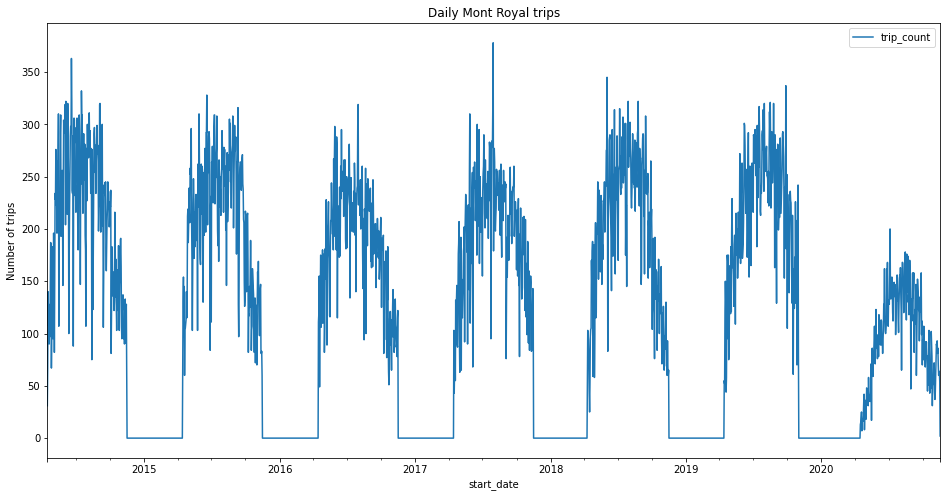

In [94]:
# Daily plot
mr_bike_demand.plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Daily Mont Royal trips')
plt.show()

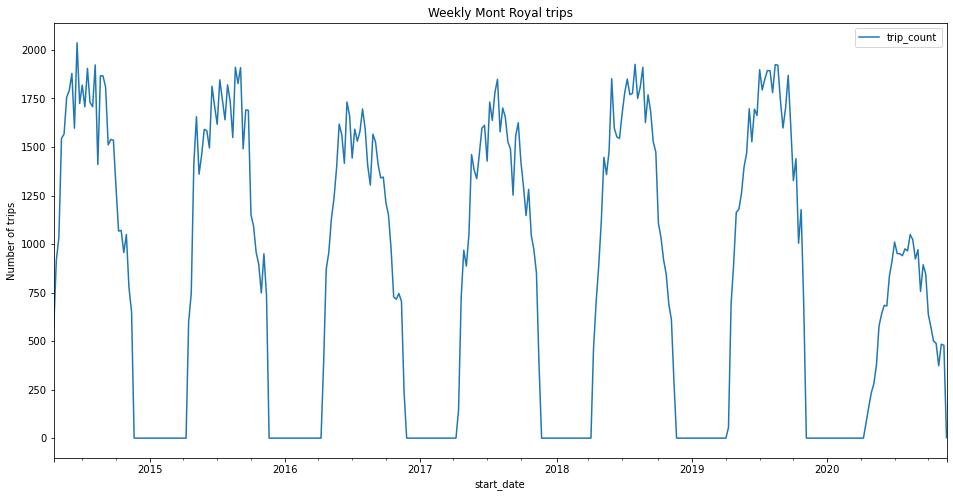

In [95]:
# Weekly plot
mr_bike_demand.resample('W').sum().plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Weekly Mont Royal trips')
plt.show()

As we can see, there is a very clear yearly periodicity on the data.

Let's zoom in on a particular year/month and examine shorter terms history.

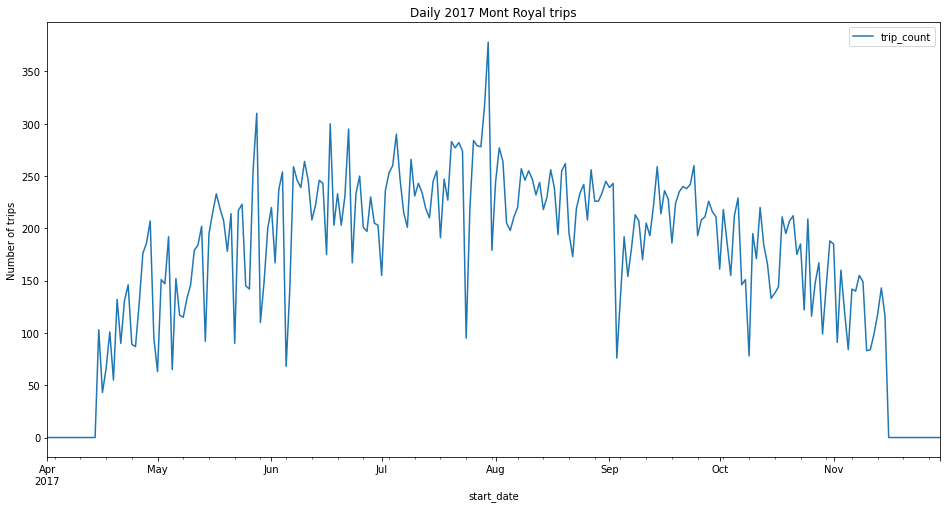

In [97]:
# Daily plot for 2017
mr_bike_demand.loc['2017-04':'2017-11'].plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Daily 2017 Mont Royal trips')
plt.show()

There is a clear pattern within this year, with the demand steadily increasing until the peak in late July/early August and then decreasing.

Let's look at the data for one month and the weekday data.

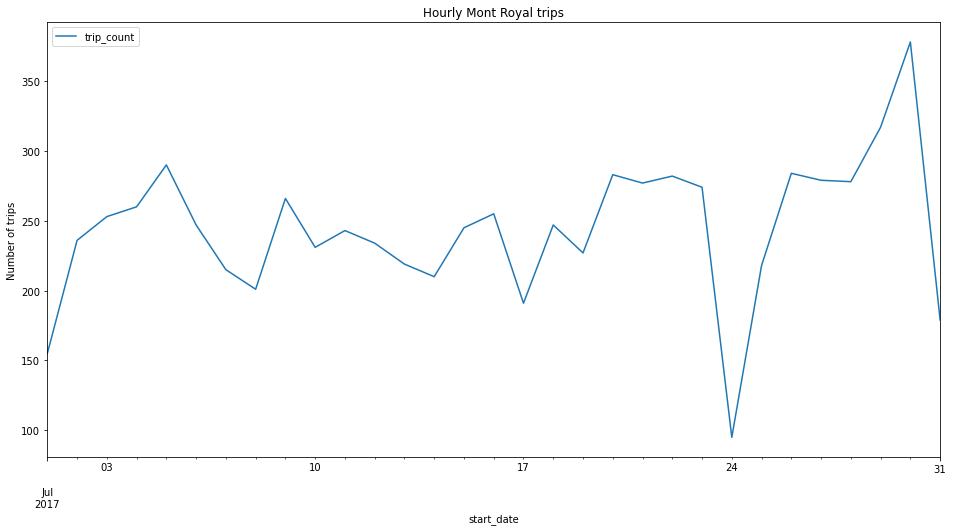

In [98]:
# Daily plot for July 2017
mr_bike_demand.loc['2017-07'].plot(figsize=(16, 8))
plt.ylabel('Number of trips')
plt.title('Hourly Mont Royal trips')
plt.show()

In [101]:
# Copy July demand into a new data frame
july_demand = mr_bike_demand.loc['2017-07'].copy()

# Add weekdays to each sample
july_demand['weekday'] = july_demand.index.day_name()

weekday
Friday       AxesSubplot(0.125,0.125;0.775x0.755)
Monday       AxesSubplot(0.125,0.125;0.775x0.755)
Saturday     AxesSubplot(0.125,0.125;0.775x0.755)
Sunday       AxesSubplot(0.125,0.125;0.775x0.755)
Thursday     AxesSubplot(0.125,0.125;0.775x0.755)
Tuesday      AxesSubplot(0.125,0.125;0.775x0.755)
Wednesday    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

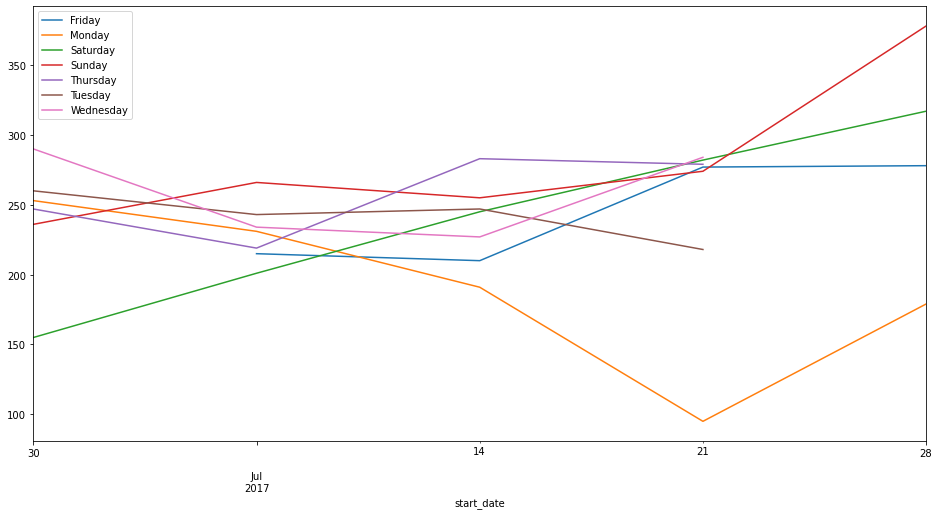

In [102]:
# Group by weekday and plot
fig, ax = plt.subplots(figsize=(16, 8))
july_demand.groupby('weekday').apply(lambda x: x['trip_count'].plot(x=x.index, ax=ax, legend=True, label=x['weekday'][0]))

**Note**: for some reason the a-axis actually evently spaces all points and does not use timestamps - need to find a way to arrange the plots properly.

## Seasonal Decomposition

Decompose the data into trend, periodic and noise components.

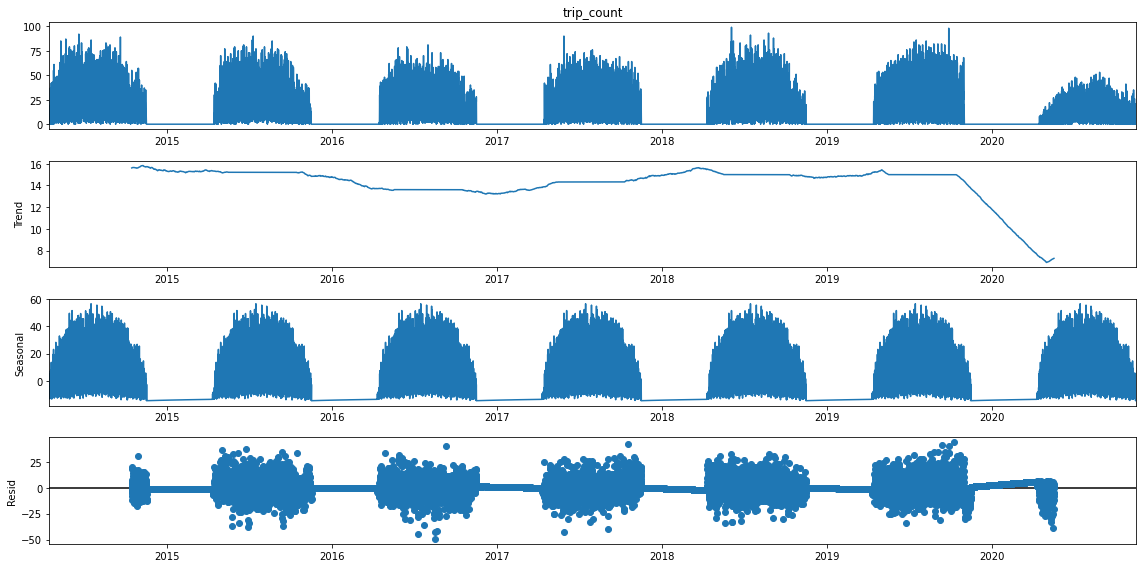

In [103]:
# Configure the period to be annual
samples_per_day = 8
days_per_year = 365
period = samples_per_day * days_per_year

plt.rc("figure", figsize=(16,8))
decomposed_trip_data = sm.tsa.seasonal_decompose(station_demand["trip_count"], period=period)
figure = decomposed_trip_data.plot()
plt.show()

A few observations:
* The trend is relatively constant throughout the years with a large dip at the end of 2019 (missing November data) and into 2020 (pandemic)
* There a strong overall yearly periodic component
* There is still a significant amount of noise among individual samples

## Autocorrelation

Let's see what the autocorrelation looks like with up to 1 year lag.

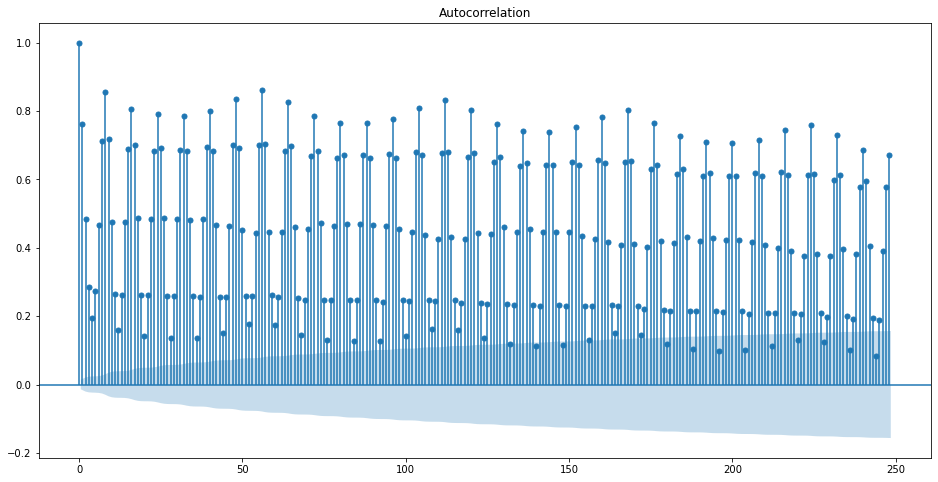

In [104]:
# Autocorrelation with up to month lag
plt.rc("figure", figsize=(16,8))
plot_acf(station_demand["trip_count"], lags=248)
plt.show()

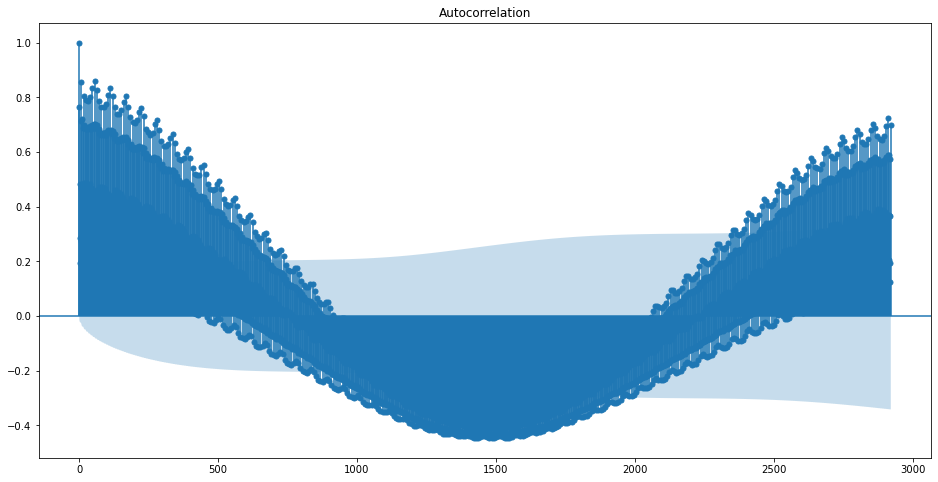

In [105]:
# Autocorrelation with up to year lag
plt.rc("figure", figsize=(16,8))
plot_acf(station_demand["trip_count"], lags=period)
plt.show()

As we can see, there is a statistically significant autocorrelation at each level:
* Previous day/week/month usage is generally correlated with the next
* Previous year usage is generally correlated with the next

# Dummy baselines

We will use **sktime** library to implement our forecasting baselines.

In [20]:
# Naive forecaster
from sktime.forecasting.naive import NaiveForecaster

# Prophet forecaster
from sktime.forecasting.fbprophet import Prophet

# Error metrics
from sktime.performance_metrics.forecasting import mean_squared_error
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# CV 
from sktime.forecasting.model_selection import ExpandingWindowSplitter

## Data Splitting

Split the data into training and test set.
* Training set: from 2014 to 2018 (inclusive)
* Test set: 2019

Since the main low-frequency data periodicity is yearly, it makes sense to do a yearly split. This split gives approximately a 5 to 1 training to test split ratio (about 83:17).

**Notes**: 
* 2020 was excluded due to overall trend dip because of the pandemic, as can be seen in the visualizations.
* 2019 is missing the data for November so using it as test data will lead to large errors for November. We might want to either use 2018 (4:1 split) as test data or somehow fill missing data for 2019.

In [21]:
# Split station data into training and test set
demand_train = station_demand['2014':'2018']
demand_test  = station_demand['2019':'2019']

# Add zeros for 2014 before April
df = pd.DataFrame(index=pd.date_range(start='2014-01-01', end='2014-04-15 03:00:00', freq='3H'), columns=['trip_count'])
df['trip_count'] = 0
demand_train = pd.concat([df, demand_train])

**Note**: there is one extra day in 2016 (leap year). Removing it seems to break the proper data frequency and letting it be shifts all periods by one. For now we leave it as it is, since the shift should make a significant impact.

## Validation

Here we define functions for Time-Series Split cross validation and held-out test data validation.

### Cross Validation

In [22]:
'''from sktime.forecasting.model_selection import ExpandingWindowSplitter

class ExpandingWindowCV:
    
       
    def __init__(self, forecaster, train_data, window_size):
        self.forecaster = forecaster
        self.train_data = train_data
        self.window_size = window_size
        
        self.forecasters = []
        self.validation_sets = []
    
    def fit(self):
        # Define a time-series split with step and forecast horizon equal to window size
        cv = ExpandingWindowSplitter(initial_window = self.window_size, 
                                     step_length = self.window_size, 
                                     fh = self.window_size)

        for (train_cutoff, validation_cutoff) in cv.split(self.train_data):
            # Extract train and test cutoff sample numbers
            train_cutoff = train_cutoff[-1] + 1
            validation_cutoff = validation_cutoff[0] + 1

            # Partition the data into training and validation sets
            train_set = self.train_data.iloc[0:train_cutoff]
            validation_set = self.train_data.iloc[train_cutoff:validation_cutoff]
            
            # Create and train a new forecaster from the prototype
            forecaster = self.forecaster.__class__()
            forecaster.set_params(**self.forecaster.get_params())
            forecaster.fit(train_set)

            # Append to trained forecasters
            print(f'Trained forecaster with cutoffs {train_cutoff}|{validation_cutoff}')
            self.forecasters.append(forecaster)
            self.validation_sets.append(validation_set)

    def plot_pred(self):
        # Compute the forecast horizon
        fh = np.arange(1, self.window_size+1)
        
        # Plot the true training data
        ax = self.train_data.resample('D').sum().plot(figsize=(16, 8))

        # Plot preditctions
        for forecaster in self.forecasters:
            # Make predictions 
            y_pred = forecaster.predict(fh)
            # Downsample data to daily and plot
            sub_plot = y_pred.resample('D').sum().plot(ax=ax, color='orange', legend=False)
            sub_plot.set_label('Label via method')
    
        # Set legend
        ax.legend(["True", "Predictions"]);
        
    def evaluate_RMSE(self):
        errors = []
        
        fh = np.arange(1, self.window_size+1)
        for (forecaster, y_true) in zip(self.forecasters, self.validation_sets):
            # Make predictions 
            y_pred = forecaster.predict(fh)
            # Append error
            errors.append(mean_squared_error(y_true, y_pred, square_root=True))

        return np.mean(errors)
    
    def evaluate_MAPE(self):
        errors = []
        
        fh = np.arange(1, self.window_size+1)
        for (forecaster, y_true) in zip(self.forecasters, self.validation_sets):
            # Make predictions 
            y_pred = forecaster.predict(fh)
            # Append error
            errors.append(mean_absolute_percentage_error(y_true, y_pred))

        return np.mean(errors)''';

In [23]:
def evaluate_cv(forecaster, train_data, window_size, 
                scoring = (MeanAbsolutePercentageError(), MeanSquaredError(square_root=True)),
                return_data = True):
    # Define the forecast horizon
    fh = np.arange(1, window_size+1)
    
    # Create a splitter for computing split thresholds
    splitter = ExpandingWindowSplitter(initial_window = window_size, 
                                        step_length = window_size, 
                                        fh = window_size)
    
    # Create a DataFrame for storing the results
    results = pd.DataFrame()
    #score_name = scoring.name
    
    # Train and evaluate the model for each split, store the results
    for (train_cutoff, validation_cutoff) in splitter.split(train_data):
        # Extract train and test cutoff sample numbers
        train_cutoff = train_cutoff[-1] + 1
        validation_cutoff = validation_cutoff[0] + 1

        # Partition the data into training and validation sets
        y_train = train_data.iloc[0:train_cutoff]
        y_val   = train_data.iloc[train_cutoff:validation_cutoff]

        # Train the model
        forecaster.fit(y_train)

        # Make predictions and evaluate
        y_pred = forecaster.predict(fh)   
        
        scores = {}
        if not isinstance(scoring, tuple):
            scoring = (scoring, )
        for scorer in scoring:
            score_name = scorer.name
            score = scorer(y_val, y_pred, y_train=y_train)
            scores[score_name] = score
        
        data = {}
        if return_data:
            data = {
                    "y_train": y_train,
                    "y_val": y_val,
                    "y_pred": y_pred,
                    }
        
        
        # Add results
        results = results.append({**scores, **data},
            ignore_index=True,
        )
              
    return results
                       
def plot_cv_results(results, train_data):
    ax = train_data.resample('D').sum().plot(figsize=(16, 8))
    
    for split in results.itertuples():
        sub_plot = split.y_pred.resample('D').sum().plot(ax=ax, color='orange', legend=False)

    # Set legend
    ax.legend(["True", "Predictions"]);

### Test Validation

In [24]:
# Define a helper function to plot the prediction and calculate error
def eval_forecast(forecaster, fh, y_true, scoring = (MeanAbsolutePercentageError(), MeanSquaredError(square_root=True))):
    # Make predictions 
    y_pred = forecaster.predict(fh)

    # Downsample data to daily and plot
    ax = y_true.resample('D').sum().plot(figsize=(16, 8))
    y_pred.resample('D').sum().plot(ax=ax)

    # Compute RMSE
    if not isinstance(scoring, tuple):
        scoring = (scoring, )
    for scorer in scoring:
        print(scorer.name + ':', scorer(y_true, y_pred))

## Seasonal Naive Baseline 

### Cross Validation

Use time-series split to perform cross-validation.

In [25]:
# Configure the seasonal period to be yearly
samples_per_day = 8
days_per_year = 365
seasonal_period = samples_per_day * days_per_year

,MeanAbsolutePercentageError,MeanSquaredError,y_pred,y_train,y_val
0,0.304021,10.640547,trip_count 2015-01-01 00:...,trip_count 2014-01-01 00:...,trip_count 2015-01-01 00:...
1,0.338095,10.633544,trip_count 2016-01-01 00:...,trip_count 2014-01-01 00:...,trip_count 2016-01-01 00:...
2,0.319733,9.924630,trip_count 2016-12-31 00:...,trip_count 2014-01-01 00:...,trip_count 2016-12-31 00:...
3,0.345420,10.746439,trip_count 2017-12-31 00:...,trip_count 2014-01-01 00:...,trip_count 2017-12-31 00:...


MeanAbsolutePercentageError     0.326817
MeanSquaredError               10.486290
dtype: float64

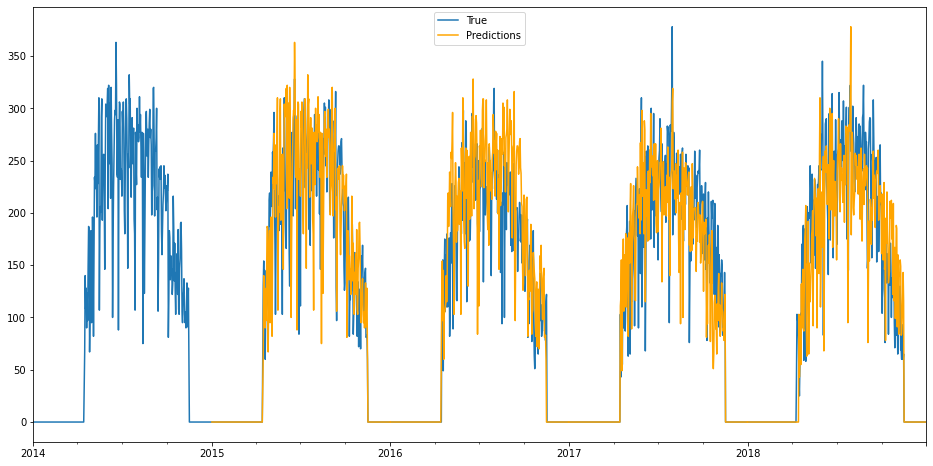

In [26]:
# Perform CV using the last strategy
forecaster = NaiveForecaster(strategy="last", sp = seasonal_period)
results = evaluate_cv(forecaster, demand_train, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
plot_cv_results(results, demand_train)

,MeanAbsolutePercentageError,MeanSquaredError,y_pred,y_train,y_val
0,0.304021,10.640547,trip_count 2015-01-01 00:...,trip_count 2014-01-01 00:...,trip_count 2015-01-01 00:...
1,0.330262,10.134549,trip_count 2016-01-01 00:...,trip_count 2014-01-01 00:...,trip_count 2016-01-01 00:...
2,0.320115,9.771345,trip_count 2016-12-31 00:...,trip_count 2014-01-01 00:...,trip_count 2016-12-31 00:...
3,0.335925,9.595457,trip_count 2017-12-31 00:...,trip_count 2014-01-01 00:...,trip_count 2017-12-31 00:...


MeanAbsolutePercentageError     0.322581
MeanSquaredError               10.035474
dtype: float64

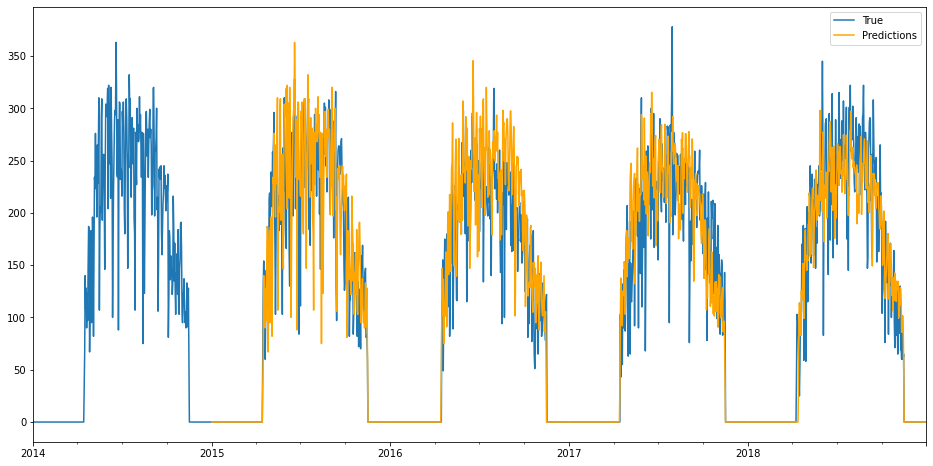

In [27]:
# Perform CV using the mean strategy
forecaster = NaiveForecaster(strategy="mean", sp = seasonal_period)
results = evaluate_cv(forecaster, demand_train, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
plot_cv_results(results, demand_train)

### Test Validation

In [28]:
# Configure forecast parameters

# Configure the seasonal period to be yearly
samples_per_day = 8
days_per_year = 365
seasonal_period = samples_per_day * days_per_year

# Configure the forecating horizon to be the length of the test set
fh = np.arange(1, len(demand_test)+1)

MeanAbsolutePercentageError: 0.40903619471071584
MeanSquaredError: 11.128914579869296


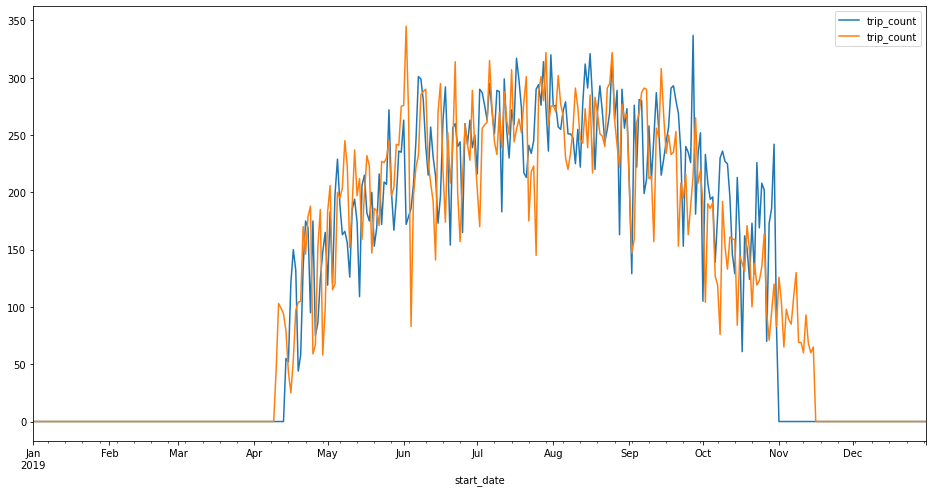

In [29]:
# Forecast using the seasonal naive random walk forecast
forecaster = NaiveForecaster(strategy="last", sp = seasonal_period) 
forecaster.fit(demand_train)

# Evaluate the forecast
eval_forecast(forecaster, fh, demand_test)

MeanAbsolutePercentageError: 0.3963479784562324
MeanSquaredError: 10.137270849393964


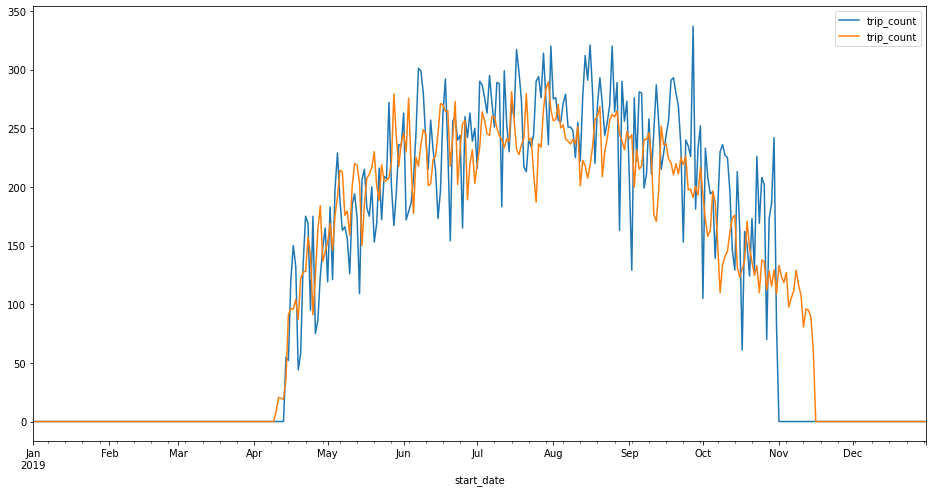

In [30]:
# Forecast using the seasonal naive mean forecast
forecaster = NaiveForecaster(strategy="mean", sp = seasonal_period) 
forecaster.fit(demand_train)

# Evaluate and plot the forecast
eval_forecast(forecaster, fh, demand_test)

## Prophet Baseline

Basic Facebook Prophet baseline.

**Note**: 
* Not tuned at all
* Default model tends to overshoot, can have negative values and does not perform all that well
* Takes a while to train

In [31]:
# Convert the training DF to a Series
y = demand_train['trip_count']

# Configure the model
forecaster = Prophet(
    seasonality_mode='additive',
    n_changepoints=25, # default
    add_country_holidays={'country_name': 'Canada'},
    yearly_seasonality=True)

### Cross Validation

,MeanAbsolutePercentageError,MeanSquaredError,y_pred,y_train,y_val
0,1.127525,10.983943,ds 2015-01-01 00:00:00 -7.899903 2015-01-01...,2014-01-01 00:00:00 0 2014-01-01 03:00:00 ...,2015-01-01 00:00:00 0 2015-01-01 03:00:00 ...
1,1.139520,10.188618,ds 2016-01-01 00:00:00 -7.404948 2016-01-01...,2014-01-01 00:00:00 0 2014-01-01 03:00:00 ...,2016-01-01 00:00:00 0 2016-01-01 03:00:00 ...
2,1.153313,10.908535,ds 2016-12-31 00:00:00 -7.398729 2016-12-31...,2014-01-01 00:00:00 0 2014-01-01 03:00:00 ...,2016-12-31 00:00:00 0 2016-12-31 03:00:00 ...
3,1.126459,11.091409,ds 2017-12-31 00:00:00 -7.393566 2017-12-31...,2014-01-01 00:00:00 0 2014-01-01 03:00:00 ...,2017-12-31 00:00:00 0 2017-12-31 03:00:00 ...


MeanAbsolutePercentageError     1.136704
MeanSquaredError               10.793126
dtype: float64

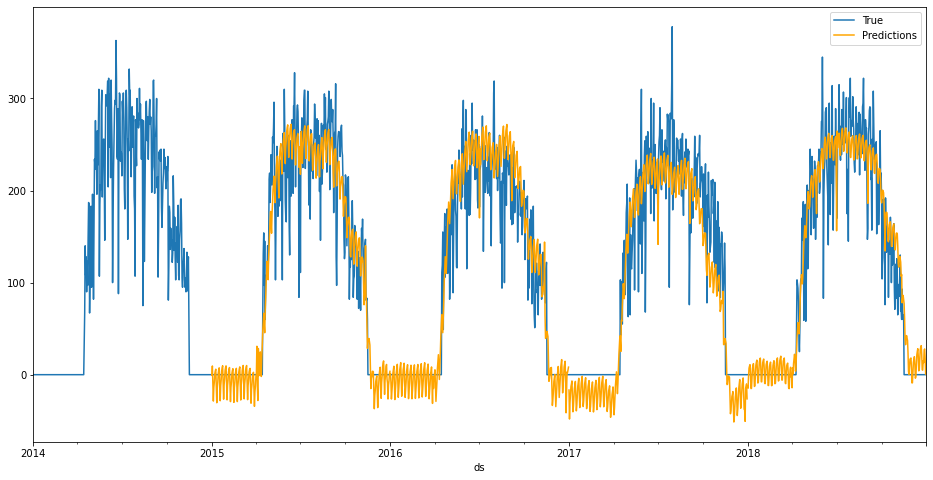

In [32]:
# Train the cross-validation models using last strategy
#cv = ExpandingWindowCV(forecaster, y, seasonal_period)
#cv.fit()

# Perform CV using the mean strategy
results = evaluate_cv(forecaster, y, seasonal_period)

# Display CV results
display(results)
display(results.mean())

# Plot CV forecasts
plot_cv_results(results, demand_train)

### Test Validation

In [33]:
# Configure the model
forecaster = Prophet(
    seasonality_mode='additive',
    n_changepoints=25, # default
    add_country_holidays={'country_name': 'Canada'},
    yearly_seasonality=True)

# Train the model
forecaster.fit(y)

Prophet(add_country_holidays={'country_name': 'Canada'},
        yearly_seasonality=True)

MeanAbsolutePercentageError: 1.2035290663242737
MeanSquaredError: 11.749017158337239


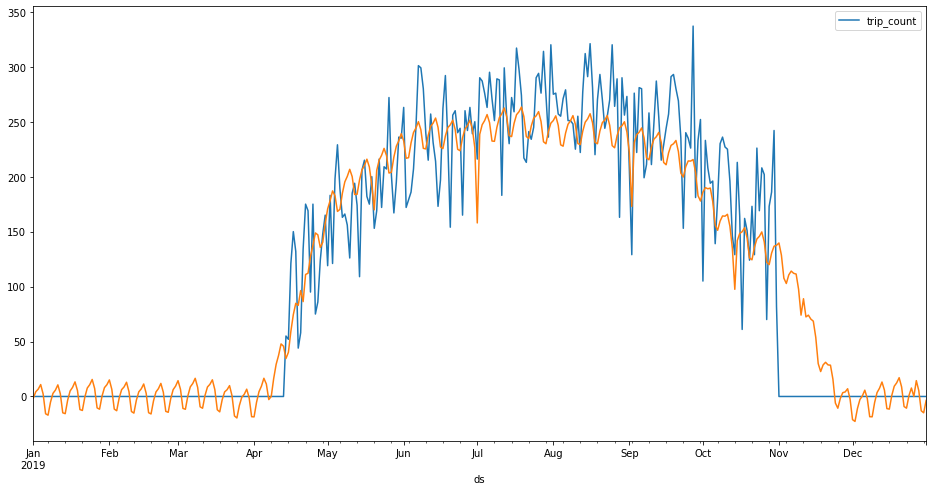

In [34]:
# Evaluate and plot the forecast
eval_forecast(forecaster, fh, demand_test)